Diferentemente do ICDAR, o dowloand do FinTabNet não é realizado automaticamente, portanto espera-se que o conjunto de dados já esteja descompactado na mesma pasta do notebook. 

# Extração dos Rótulos

In [ ]:
import os
from pathlib import Path
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd

In [ ]:
from DataExtractor.xml_handler import XMLHandler
from DataAugmentation.augmentation import Augmentation

NO PROJETO DE QUALIFICAÇÃO, EMPREGAR THREADS PARA PROCESSAR ESSE VOLUME DE DADOS. 

A extração dos rótulos é feita ao acessar as pastas com as anotações de cada split train, val, test. As anotações estão em arquivos XML, sendo que há um XML por imagem. Em geral, até onde foi visto, as imagens são de tabelas individuais. No XML, há campos específicos com metadados das imagens, como altura e largura, além das coordenadas das bounding boxes. As anotações são armazenadas em um DataFrame convertido para um arquivo csv. 

In [ ]:
#path_dataset = 'C:\\Users\\Lucas Zampar\\Downloads\\FinTabNet.c-Structure (1)\\FinTabNet.c-Structure\\'
path_dataset = 'fin_tab_net_dataset'
path_dataset = Path(path_dataset)
splits = ['train', 'val', 'test']

for split in splits:
    path_labels = path_dataset/split
    split_xml_paths = [path_labels/xml_path  for xml_path in os.listdir(path_labels)]

    all_instances_rows = []

    for xml_path in tqdm(split_xml_paths, desc=f'Gerando o DataFrame do split: {split}...'):
        
        xml_handler = XMLHandler(xml_parser=ET, xml_path=xml_path)
        root = xml_handler.get_root()

        file_metadata = xml_handler.get_values_from_parent(root, ['filename', 'path', 'segmented'])
        database_values = xml_handler.find_element_and_get_children_values(root, 'source',  ['database'])[1]
        images_values = xml_handler.find_element_and_get_children_values(root, 'size', ['width', 'height', 'depth'])[1]

        file_metadata.update(database_values)
        file_metadata.update(images_values)
        file_metadata.update({'split': split})

        ###########################################################################################

        object_element_properties = ['name', 'pose', 'truncated', 'difficult', 'occluded']
        bndbox_element_properties = ['xmin', 'ymin', 'xmax', 'ymax']

        all_object_elements = xml_handler.find_all_elements(root, 'object')

        for object_element in all_object_elements:
            
            instance = {}
            object_metadata = {}
            
            object_properties = xml_handler.get_values_from_parent(object_element, object_element_properties)
            object_metadata.update(object_properties)
            
            bndbox_element = xml_handler.find_element(object_element, 'bndbox')
            bndbox_properties = xml_handler.get_values_from_parent(bndbox_element, bndbox_element_properties)
            object_metadata.update(bndbox_properties)

            instance = file_metadata | object_metadata
            all_instances_rows.append(instance)
    
    instances_df = pd.DataFrame(all_instances_rows)
    instances_df.to_csv(path_dataset/f'{split}_dataset.csv', index=False)
            


# Selecionando Subconjnuto de Amostras

Como o conjunto é muito extenso para os recursos que tínhamos a disposição, nós selecionamos apenas uma amostra. No caso, o tamanho desse subconjunto levou em consideração o total de dados em todos os 5 folds empregados para treinar os modelos com o ICDAR. Assim, há um total de 5x(4x480 + 120) dados, 5 por conta dos folds, 4 porque há 4 variaçãoes da mesma imagem por conta dos aumentos, 480 porque há 480 imagens de treinamento e 120 imagens de validação. 80% dos dados do subconjunto do FinTabNet foram destinados para treinamento e 20% para validação. Todas as imagens foram redimensionadas para 640x640 que é o tamanho recomendado pela Ultralytics para o YOLO. As imagens são copiadas para um diretório seprado.

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm import tqdm

from DataExtractor.yolo_converter import YOLOConverter
from DataAugmentation.augmentation import Augmentation


In [ ]:
# para controlar aleatoriedade do numpy
generator = np.random.default_rng(seed=42)

In [ ]:
sampled_resized_dataset_path = Path('sampled_resized_fintabnet/')
os.makedirs(sampled_resized_dataset_path, exist_ok=True)

In [ ]:
dataset_path = Path('fin_tab_net_dataset')
images_dataset_path = dataset_path/'images/'

In [ ]:
new_width, new_height = 640, 640
splits = ['train', 'val']

In [ ]:
for split in splits:
    
    os.makedirs(sampled_resized_dataset_path/split, exist_ok=True)
    
    dataset_df = pd.read_csv(dataset_path/f'{split}_dataset.csv')
    filenames = dataset_df['filename'].unique()

    total_icdar_samples = 5*(4*480 + 120)
    
    if split == 'train':
        total_fintabnet_samples = int(total_icdar_samples * .8) # 8160
    else:
        total_fintabnet_samples = int(total_icdar_samples * .2) # 2040
    
    samples_filenames = generator.choice(filenames, replace=False, size=total_fintabnet_samples)

    pbar = tqdm(samples_filenames,  )


    all_instances = []

    for filename in pbar:

        image_annontations = dataset_df.query(f"filename == '{filename}'")

        image_filename = filename
        image_path = images_dataset_path/image_filename
        image = Image.open(image_path)
        image = np.array(image)

        image_width = image_annontations['width'].iloc[0]
        image_height = image_annontations['height'].iloc[0]
        names = image_annontations['name'].tolist()

        bboxes = []
        for _, bounding_box in image_annontations[['xmin', 'xmax', 'ymin', 'ymax']].iterrows():
            xmin = float(bounding_box['xmin'])
            ymin = float(bounding_box['ymin'])
            xmax = float(bounding_box['xmax'])
            ymax = float(bounding_box['ymax'])

            bboxes.append([[xmin, ymin], [xmax, ymax]])

        output_path = sampled_resized_dataset_path/split/f'{image_filename}'

        pbar.set_description(f'Convertendo imagem {image_filename} ({image.shape[1]}X{image.shape[0]}) -> ({new_width}X{new_height})')

        resized_image, resized_bboxes = \
            Augmentation.resize_image(image, new_width, new_height, masks=bboxes)
        
        
        yolo_bboxes = YOLOConverter.convert_bounding_boxes_xy2yolo(resized_bboxes, new_width, new_height)


        Augmentation.save_image(resized_image, output_path)

        instance = {'filename': filename, 
                    'original_path': image_path,
                    'path':output_path,
                    'split': split,
                    'original_width': image_width,
                    'original_height': image_height,
                    'width': new_width,
                    'height': new_height,
                    'original_names' : names,
                    'original_bboxes': bboxes,
                    'bboxes': resized_bboxes,
                    'yolo_bboxes': yolo_bboxes}
        
        all_instances.append(instance)

    dataset_df = pd.DataFrame(all_instances)
    dataset_df.to_csv(sampled_resized_dataset_path/f'{split}_dataset.csv', index=False)
   

# Gerando Anotações YOLO 

As anotações são convertidas para o formato YOLO esperado, isto é, com os arquivos txt contendo coordenadas das bounding boxes $X_c$, $Y_c$, $W$, $H$ normalizadas. Além disso, o projeto é organizado com as pastas `train/` e `val/` contendo cada uma as subpastas `images/` e `labels/`. As imagens tratadas e as anotações são copiadas as para as respectiva subpastas. 

In [23]:
import os
import shutil
import numpy as np
import pandas as pd
import json
from PIL import Image
from pathlib import Path
from tqdm import tqdm


from DataExtractor.yolo_converter import YOLOConverter

In [3]:
dataset_path = Path('fin_tab_net_dataset/')
sampled_dataset_path = Path('sampled_resized_fintabnet/')

In [ ]:
# criação da estrutura de diterório esperada
YOLOConverter.create_folders(sampled_dataset_path)

In [ ]:
# copia as imagens de cada split para a respectiva subpasta images/
splits = ['train', 'val']

for split in splits:
    split_path = sampled_dataset_path/split
    for path in os.listdir(split_path):
        path = split_path/path
        if os.path.isfile(path):
            shutil.move(path, split_path/'images/')


## Exploração dos dados

In [ ]:
from DataVisualization.object_detection_visualization import *

Aqui, foi feita uma breve exploração dos dados para gerar algumas estatísticas descritivas como a distribuição de classes. É notado um certo desbalanceamento com classes que representam as colunas do cabeçalho (table column header) e linhas projetadas no cabeçalho (table projected row header). De fato, essas classes tendem a ocorrer menos em tabelas, uma vez que há a predominância de linhas e colunas. Tal desbalanceamento não foi tratado diretamente no trabalho, no entanto os modelos YOLO da Ultralyticas são treinados com a fundção de custo DualFocal que tenta tratar desbalanceamentos. 

In [6]:
train_df = pd.read_csv(sampled_dataset_path/'train_dataset.csv')
val_df = pd.read_csv(sampled_dataset_path/'val_dataset.csv')

In [7]:
# 'Historgrama' das classes
for split in splits:
    all_names = []
    if split == 'train':
        df = train_df
    else: 
        df = val_df

    for names_list in df['original_names']:
        names_list = names_list.replace('\'', '"')  
        names = json.loads(names_list)
        all_names.extend(names)
    
    print(f'{split}:')
    
    unique_names, counts = np.unique(all_names, return_counts=True)
    total = sum(counts)

    for name, count in zip(unique_names, counts):
        print(f'\t{name}: {count} = {count/total:.2%}')


train:
	table: 8160 = 4.83%
	table column: 36144 = 21.38%
	table column header: 7682 = 4.55%
	table projected row header: 9274 = 5.49%
	table row: 97761 = 57.84%
	table spanning cell: 9998 = 5.92%
val:
	table: 2040 = 5.22%
	table column: 8812 = 22.55%
	table column header: 1932 = 4.94%
	table projected row header: 1776 = 4.54%
	table row: 22490 = 57.55%
	table spanning cell: 2031 = 5.20%


Além disso, foram realizadas algumas visualização das anotações para entender o que extamanete essas classes minoritárias representam. 

In [8]:
for _, row in train_df.iterrows():
    if 'table projected row header' in row['original_names']:
        break

In [9]:
filename = row['filename']
bboxes = json.loads(row['bboxes'])
names = json.loads(row['original_names'].replace('\'', '"'))

image_path = sampled_dataset_path/'train'/'images'/filename
image = Image.open(image_path)
#image

In [10]:
for bbox, name in zip(bboxes, names):
    if name in ['table', 'table column', 'table row']: 
        continue
    xmin, ymin, xmax, ymax = sum(bbox, [])
    bbox_color = fintab_color_class_map[name]
    image = draw_bouding_box(np.array(image), xmin, ymin, xmax, ymax, bbox_color=bbox_color,  
                             bbox_class=name, font_color=bbox_color, font_scale=.3, font_thickness=1)


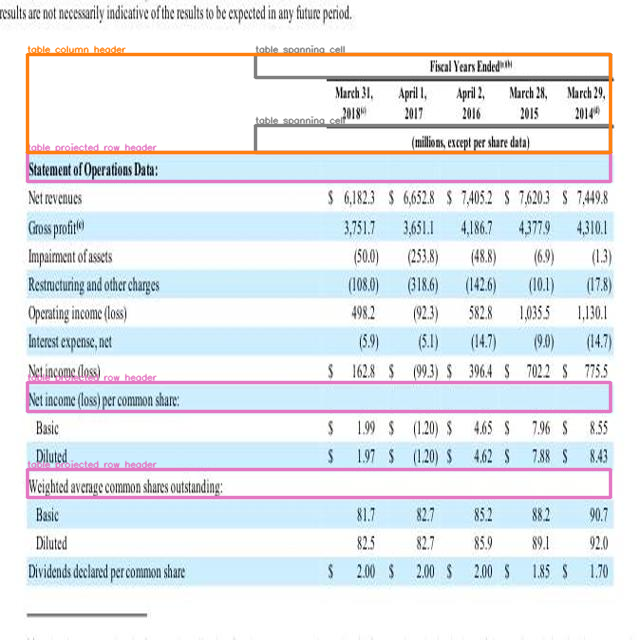

In [11]:
Image.fromarray(image)

## Retornando a Geração de Anotações

Finalizada a análise exploratória dos dados, o processo de geração das anotações é retornado. 

Existe um certo desbalanceamento entre as classes, mas iremos continuar com esse desbalanceamento. 

In [12]:
class_id_map = {
    'table': 0, 
    'table column': 1,
    'table column header' : 2,
    'table projected row header' : 3,
    'table row' : 4,
    'table spanning cell' : 5
}

In [13]:
class_ids = class_id_map.values()
class_labels = class_id_map.keys()

class_ids, class_labels

(dict_values([0, 1, 2, 3, 4, 5]),
 dict_keys(['table', 'table column', 'table column header', 'table projected row header', 'table row', 'table spanning cell']))

In [18]:
yaml_content = YOLOConverter.create_yaml_content(
                                output_dir=f'{sampled_dataset_path}/',
                                train_fold_path='train/',
                                val_fold_path='val/',
                                class_ids = class_ids, 
                                class_labels = class_labels,
                                task='detect')

print(yaml_content)

path: sampled_resized_fintabnet/
train: train/
val: val/
task : detect

names:
	0: table
	1: table column
	2: table column header
	3: table projected row header
	4: table row
	5: table spanning cell



In [20]:
YOLOConverter.save_file(yaml_content, sampled_dataset_path/'dataset.yaml')

In [28]:
splits = ['train', 'val']

for split in splits:
    labels_path = sampled_dataset_path/split/'labels/'
    dataset_df = pd.read_csv(sampled_dataset_path/f'{split}_dataset.csv')
    
    for _, row in tqdm(dataset_df.iterrows(), total=dataset_df.shape[0], desc=f'Gerando TXTs do split {split}: '): 
        image_filename = row['filename']
        image_filename = os.path.splitext(image_filename)[0]
        txt_path = labels_path/f'{image_filename}.txt'

        class_names = json.loads( row['original_names'].replace('\'', '"'))
        bboxes = json.loads(row['yolo_bboxes'])

        class_ids = [class_id_map[class_name] for class_name in class_names]

        txt_content = YOLOConverter.create_bbox_txt_file_content(bboxes, class_ids)
        YOLOConverter.save_file(txt_content, txt_path)
    


Gerando TXTs do split val: 100%|██████████| 2040/2040 [00:00<00:00, 2237.65it/s]


# Código Antigo para Redimensionar as Imagnes (NÃO USAR)

Código alternativo para aplicar o redimensionamento para todo conjunto de dados:

NO PROJETO DE QUALIFICAÇÃO, EMPREGAR THREADS PARA PROCESSAR ESSE VOLUME DE DADOS. 

In [ ]:
'''
splits = ['train', 'val', 'test']
new_width, new_height = 640, 640 

for split in splits:

    dataset_df = pd.read_csv(dataset_path/f'{split}_dataset.csv')
    pbar = tqdm(dataset_df['filename'].unique())

    os.makedirs(resized_dataset_path/split, exist_ok=True)

    all_instances = []

    for filename in pbar:

        image_annontations = dataset_df.query(f"filename == '{filename}'")

        image_filename = filename
        image_path = images_dataset_path/image_filename
        image = Image.open(image_path)
        image = np.array(image)

        image_width = image_annontations['width'].iloc[0]
        image_height = image_annontations['height'].iloc[0]
        names = image_annontations['name'].tolist()

        masks = []
        for _, bounding_box in image_annontations[['xmin', 'xmax', 'ymin', 'ymax']].iterrows():
            xmin = float(bounding_box['xmin'])
            ymin = float(bounding_box['ymin'])
            xmax = float(bounding_box['xmax'])
            ymax = float(bounding_box['ymax'])

            masks.append([[xmin, ymin], [xmax, ymax]])

        output_path = resized_dataset_path/split/f'{image_filename}'

        pbar.set_description(f'Convertendo imagem {image_filename} ({image.shape[1]}X{image.shape[0]}) -> ({new_width}X{new_height})')

        resized_image, resized_masks = \
            Augmentation.resize_image(image, new_width, new_height, masks=masks )
        
        Augmentation.save_image(resized_image, output_path)

        instance = {'filename': filename, 
                    'original_path': image_path,
                    'path':output_path,
                    'split': split,
                    'original_width': image_width,
                    'original_height': image_height,
                    'width': new_width,
                    'height': new_height,
                    'original_names' : names,
                    'original_bboxes': masks,
                    'bboxes': resized_masks}
        
        all_instances.append(instance)

    dataset_df = pd.DataFrame(all_instances)
    dataset_df.to_csv(resized_dataset_path/f'{split}_dataset.csv', index=False)
'''